# Predictive Agent: Loan Approval Classification System
#### Project Description
The Predictive Agent is a machine learning module responsible for predicting whether a loan application will be approved or denied based on a combination of structured financial data and insights extracted from the applicant’s textual justification.


This agent enables financial institutions to make faster, data riven decisions by analyzing not only traditional credit related metrics but also the applicant's intent and context expressed in natural language.



#### Objectives
        Build a supervised classification model to predict the binary Loan Approval outcome (1 = Approved, 0 = Denied).
        
        Combine structured financial data with NLP-derived features like:
        
        Sentiment score from loan justification text
        
        Topic category representing the main theme of the justification
        
        Test multiple machine learning models (Logistic Regression, Random Foreset classifier, SVC).
        
        Apply cross-validation and hyperparameter tuning to select the best-performing model.
        
        Generate predictions on new applications and support live deployment in the pipeline.

#### Input Features
Structured financial attributes:

        Income
        
        Credit Score
        
        Loan Amount
        
        DTI Ratio
        
        Employment Status

NLP-derived attributes:

        Sentiment (e.g., positive/neutral/negative or continuous score)
        
        Topic (e.g., business expansion, education, medical emergency, etc.)

#### Output
        Prediction: Binary classification (Approved or Denied)
        
        Probability: Confidence score for the prediction (optional)
        
        Model Evaluation: Metrics across training, validation, test, and raw sets:
        
        Accuracy, Precision, Recall, F1-score, AUC
        
        Variance reporting to assess overfitting or underfitting

In [47]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, classification_report, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.utils import resample
# SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution
from imblearn.over_sampling import SMOTE , ADASYN

# FEature Importance
import shap
from sklearn.inspection import permutation_importance


# Preprocessing
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline

# Error handling
import warnings
warnings.filterwarnings("ignore")

### Import data 


In [3]:
df = pd.read_csv('../data/cleaned/topic_label_check.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Income             24000 non-null  int64  
 1   Credit_Score       24000 non-null  int64  
 2   Loan_Amount        24000 non-null  int64  
 3   DTI_Ratio          24000 non-null  float64
 4   Employment_Status  24000 non-null  object 
 5   Sentiment          24000 non-null  object 
 6   topic              24000 non-null  int64  
 7   Approval           24000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 1.5+ MB


In [5]:
df.columns

Index(['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio',
       'Employment_Status', 'Sentiment', 'topic', 'Approval'],
      dtype='object')

In [6]:
df.duplicated().sum()

0

In [7]:
df.nunique()

Income               22456
Credit_Score           551
Loan_Amount          21249
DTI_Ratio             8033
Employment_Status        2
Sentiment                3
topic                    6
Approval                 2
dtype: int64

In [8]:
# Remember no missing values, No duplicates
# Data contains two categorical columns ( employement_status and Approval which is our target variable )

### EDA

#### Target variable , Approval 

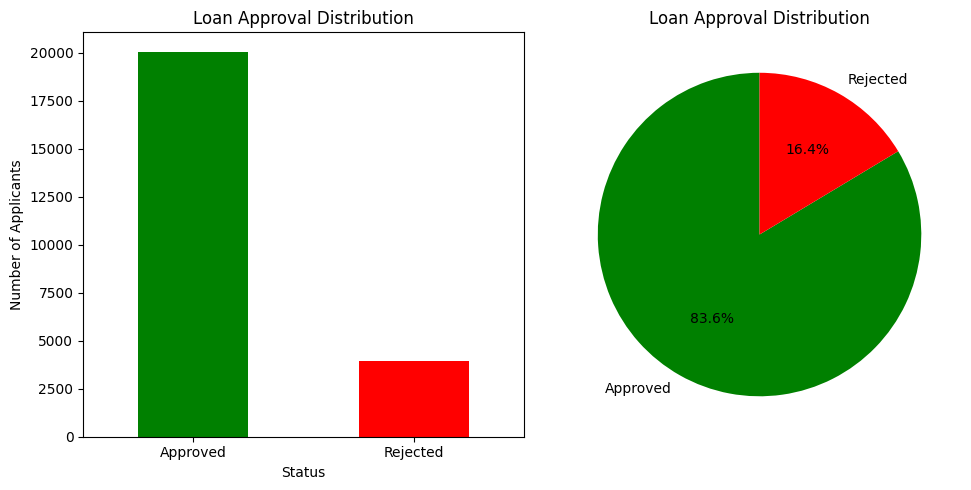

In [9]:
counts = df['Approval'].value_counts()
# Rename the indices
counts.index = ['Approved', 'Rejected']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Bar Plot on the first subplot (ax1)
counts.plot(kind='bar', color=['green', 'red'], title="Loan Approval Distribution", ax=ax1)
ax1.set_xlabel("Status")
ax1.set_ylabel("Number of Applicants")
ax1.tick_params(axis='x', rotation=0)


# Pie Chart on the second subplot (ax2)
ax2.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
ax2.set_title("Loan Approval Distribution")

# Display the subplots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Determinant analysis 

#### Income Analysis 


Do approved applicants generally have higher income?

Are there overlaps, or does income sharply separate approvals?

Are there outliers (like high income applicants who were denied?)

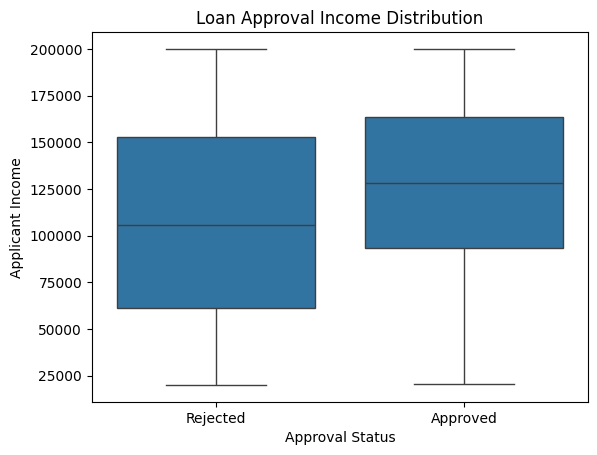

In [10]:
sns.boxplot(data=df, x='Approval', y='Income')
plt.title('Loan Approval Income Distribution')
plt.xlabel('Approval Status')
plt.ylabel('Applicant Income')
plt.show()

Insights :

        1. Generally the approved applicants have income above the average income of the rejected status applicants. Income doesnt sharply seperate the two groups, but we see a visible difference even with the overlaps. and lastly, there are high income applicants (salary > $125000) who were denied, no low income earners was approved. 

#### *Topic Trend Across Approvals*


Which topics are common in approved vs denied applications?

Do topics like "business expansion" get approved more often than "emergency medical"?

Are some topics consistently denied?

<Axes: xlabel='topic', ylabel='count'>

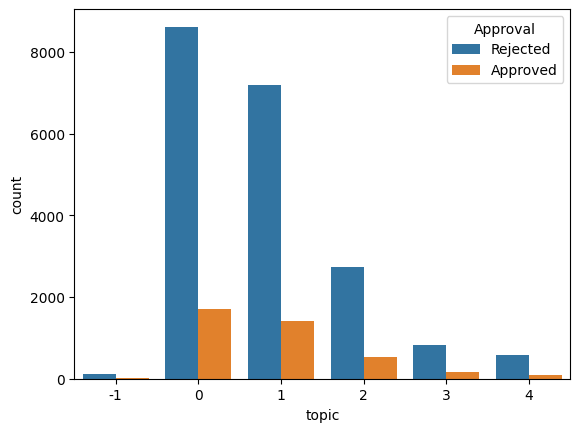

In [11]:
sns.countplot(data=df, x='topic', hue='Approval')

Insight:
          
           It is obvious here no one from the outlier group(-1) was approved a loan, and only a small group from each topic labels got approved.

#### Employemnt status and DTi trend

    Employment Status: Are unemployed applicants more likely to be denied?

    DTI Ratio: Higher ratios usually correlate with denials, is that whats happening here?
    
    Credit Score: Do approvals track strongly with higher scores?
    
    Loan Amount: Are bigger loans more likely to be rejected

<Axes: xlabel='Employment_Status', ylabel='count'>

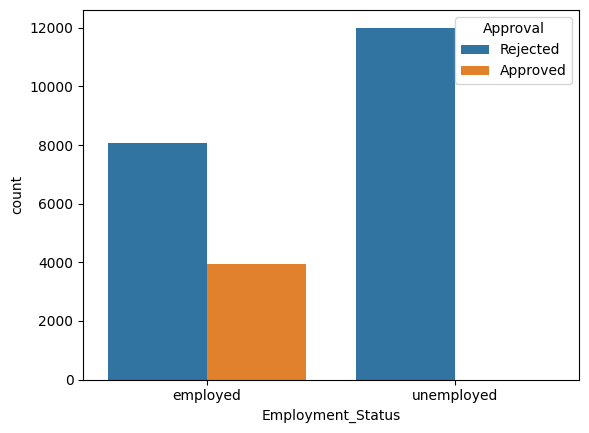

In [12]:

sns.countplot(data=df, x='Employment_Status', hue='Approval')

<Axes: xlabel='Approval', ylabel='DTI_Ratio'>

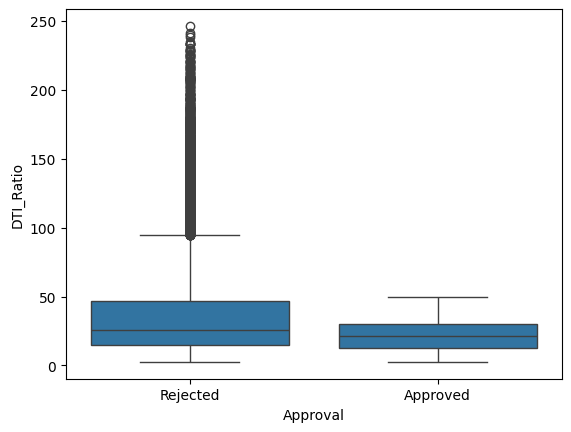

In [13]:
sns.boxplot(data=df, x='Approval', y='DTI_Ratio')

<Axes: xlabel='Approval', ylabel='Credit_Score'>

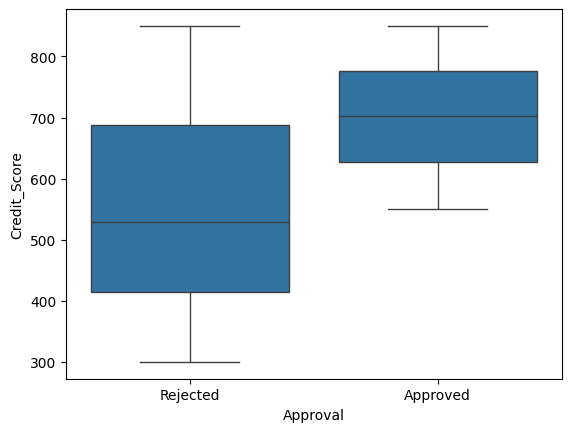

In [14]:
sns.boxplot(data=df, x='Approval', y='Credit_Score')

<Axes: xlabel='Approval', ylabel='Loan_Amount'>

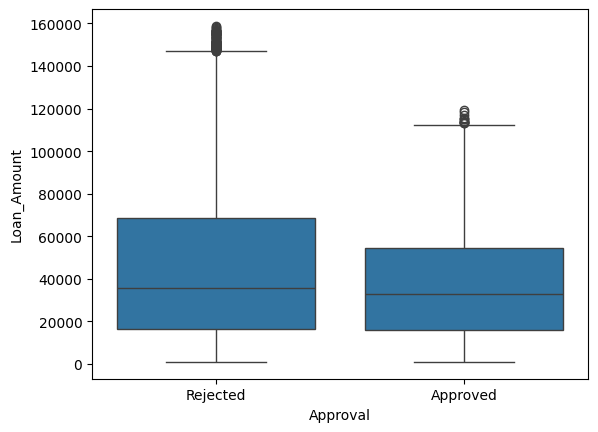

In [15]:
sns.boxplot(data=df, x='Approval', y='Loan_Amount')

Insight 
    
     Unemployed applicant do not get thier loan application approved, 
     Usually a higher loan amount gets rejected but we have few exempted cases, 
     yes, a higher credit scores correlates positively to getting your loan approved.
     All applicants with higher DTI ratio gets rejected, and we have approvals with clients with lesser dti ratios.
     

<Axes: xlabel='Income', ylabel='Density'>

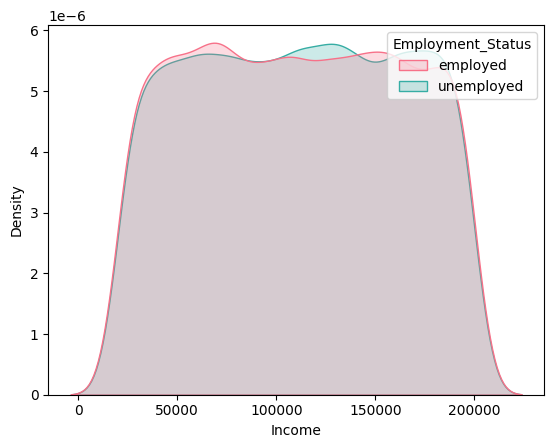

In [16]:
sns.kdeplot(data=df, x='Income', hue='Employment_Status',fill=True,common_norm=False,palette='husl')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Income             24000 non-null  int64  
 1   Credit_Score       24000 non-null  int64  
 2   Loan_Amount        24000 non-null  int64  
 3   DTI_Ratio          24000 non-null  float64
 4   Employment_Status  24000 non-null  object 
 5   Sentiment          24000 non-null  object 
 6   topic              24000 non-null  int64  
 7   Approval           24000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 1.5+ MB


<Axes: xlabel='Loan_Amount', ylabel='Density'>

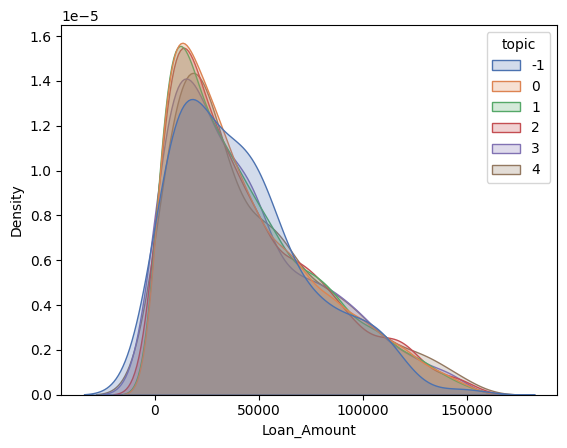

In [18]:
sns.kdeplot(data=df, x='Loan_Amount', hue='topic',fill=True,common_norm=False,palette='deep')

Correlation Analysis

In [19]:
df.columns

Index(['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio',
       'Employment_Status', 'Sentiment', 'topic', 'Approval'],
      dtype='object')

In [20]:
exclude_cols = ['topic', 'Approval', 'Sentiment_Encoded','Employment_Status'] # categorical columns 

num_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

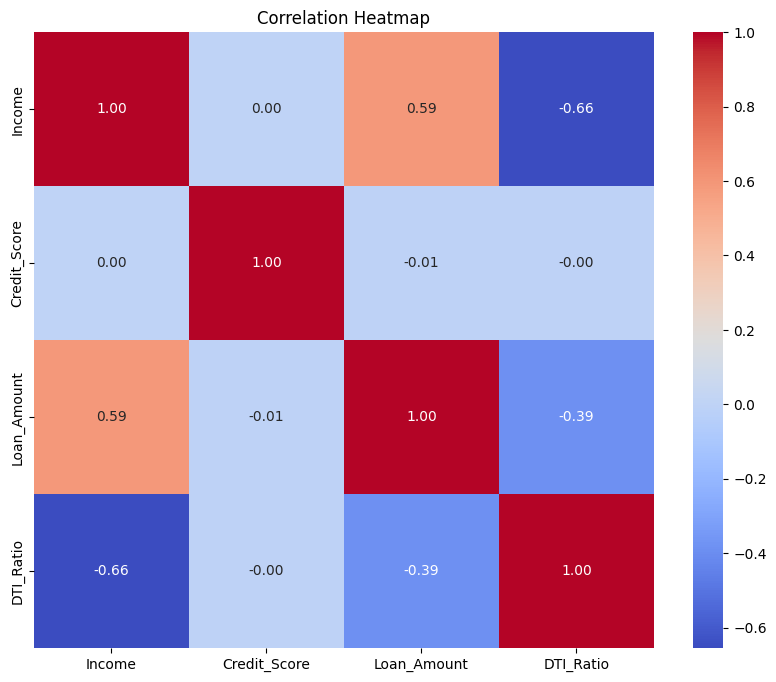

In [21]:
# initiate  Correlation matrix
corr_matrix = df[num_cols].corr()

#  Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### Feature Engineering


In [22]:
df2 = df.copy()

In [23]:
for col in df2.columns:
    if pd.api.types.is_numeric_dtype(df[col]):   # all int64 and float dtype columns
        skew_val = df2[col].skew()
        flag = ' (Highly skewed)' if abs(skew_val) > 1 else ''  # flag skewed columns
        print(f"Skewness of '{col}': {skew_val:.4f}{flag}")

Skewness of 'Income': -0.0028
Skewness of 'Credit_Score': 0.0025
Skewness of 'Loan_Amount': 0.9029
Skewness of 'DTI_Ratio': 2.3462 (Highly skewed)
Skewness of 'topic': 1.1781 (Highly skewed)


In [24]:
# transform DTI_Ration using log transformation, topic is categorical ,doesn't need transformation.
df2['DTI_Ratio'] = np.log1p(df2['DTI_Ratio'])


Encode Categorical variables

In [25]:
# map sentiment labels
df2['Sentiment_Encoded'] = df2['Sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
df2.drop(columns='Sentiment', inplace=True)
# one hot encode Employemnt status
df2 = pd.get_dummies(df2, columns=['Employment_Status'], drop_first=True)
# label encode target variable
df2['Approval_Encoded'] = df2['Approval'].map({'Rejected': 0, 'Approved': 1})
df2['Approval']= df2['Approval_Encoded']
df2.drop(columns='Approval_Encoded', inplace=True)



In [26]:
df2.columns

Index(['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'topic',
       'Approval', 'Sentiment_Encoded', 'Employment_Status_unemployed'],
      dtype='object')

In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Income                        24000 non-null  int64  
 1   Credit_Score                  24000 non-null  int64  
 2   Loan_Amount                   24000 non-null  int64  
 3   DTI_Ratio                     24000 non-null  float64
 4   topic                         24000 non-null  int64  
 5   Approval                      24000 non-null  int64  
 6   Sentiment_Encoded             24000 non-null  int64  
 7   Employment_Status_unemployed  24000 non-null  bool   
dtypes: bool(1), float64(1), int64(6)
memory usage: 1.3 MB


In [28]:
df2.head()

,Income,Credit_Score,Loan_Amount,DTI_Ratio,topic,Approval,Sentiment_Encoded,Employment_Status_unemployed
0,26556,581,8314,4.385271,1,0,1,False
1,61853,732,19210,3.809547,0,1,1,False
2,108236,404,50797,2.419479,1,0,0,False
3,197392,389,111604,3.141563,2,0,2,False
4,44561,523,34118,3.838161,2,0,1,False


#### Split data 


In [29]:
X = df2.drop(columns=['Approval'])  # Featrres 
y = df2['Approval']   # target variable 

In [30]:
X

,Income,Credit_Score,Loan_Amount,DTI_Ratio,topic,Sentiment_Encoded,Employment_Status_unemployed
0,26556,581,8314,4.385271,1,1,False
1,61853,732,19210,3.809547,0,1,False
2,108236,404,50797,2.419479,1,0,False
3,197392,389,111604,3.141563,2,2,False
4,44561,523,34118,3.838161,2,1,False
...,...,...,...,...,...,...,...
23995,195242,817,16403,3.231595,1,1,False
23996,150246,729,101572,2.395164,0,1,False
23997,64571,650,30533,4.066459,0,1,False
23998,115825,418,89837,2.430978,0,2,True


In [31]:
#  First split: Train + Temp  so 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: Train + Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)


In [32]:
print({X_train.shape})

print({X_val.shape})

print({X_test.shape})





{(14400, 7)}
{(4800, 7)}
{(4800, 7)}


#### Apply BAlacing technique as the destribution class of Approved loan request is the minority group making app. 16%


In [33]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [34]:
print(f"Before Smote : {y_train.value_counts()}")
print(f'after Smote: {pd.Series(y_resampled).value_counts()}')


Before Smote : Approval
0    12040
1     2360
Name: count, dtype: int64
after Smote: Approval
1    12040
0    12040
Name: count, dtype: int64


Scale Numerical variables 


In [35]:
#fit scaler on x_resample

scaler = StandardScaler()
scaler.fit(X_resampled[num_cols])

# transform x_resampled and other sets


X_resampled[num_cols] = scaler.transform(X_resampled[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])



### Multivarant Analysis - ML


In [36]:
# Initialize models
models = {
    'lr': LogisticRegression(C=0.1),
    'dtc': DecisionTreeClassifier(max_depth=3),
    'rfc': RandomForestClassifier()
}


In [37]:
# Use cross-validation to check scores on multiple splits
for name, model in models.items():
    print(name) 
    
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5)
    print("Mean CV score:", cv_scores.mean())
    print("Standard deviation:", cv_scores.std()) 
    print(f"cross validation scores: {cv_scores}")
    print("___"*10)

lr
Mean CV score: 0.9258720930232558
Standard deviation: 0.00832120635777154
cross validation scores: [0.91050664 0.93293189 0.93355482 0.92545681 0.9269103 ]
______________________________
dtc
Mean CV score: 0.967234219269103
Standard deviation: 0.002023409919448466
cross validation scores: [0.964701   0.96781561 0.96802326 0.96532392 0.97030731]
______________________________
rfc
Mean CV score: 0.9898255813953488
Standard deviation: 0.010324591778622263
cross validation scores: [0.9692691  0.99605482 0.99314784 0.99543189 0.99522425]
______________________________


In [38]:
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [39]:
# Train models on resampled data
for name, model in models.items():
    model.fit(X_resampled, y_resampled)

In [40]:
# evaluate on validation set 
for name, model in models.items():
    y_val_pred = model.predict(X_val)
    print(f"\n{name.upper()} Performance:\n")
    print(classification_report(y_val, y_val_pred))


LR Performance:

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      4014
           1       0.62      0.91      0.73       786

    accuracy                           0.89      4800
   macro avg       0.80      0.90      0.83      4800
weighted avg       0.92      0.89      0.90      4800


DTC Performance:

              precision    recall  f1-score   support

           0       1.00      0.93      0.97      4014
           1       0.75      1.00      0.85       786

    accuracy                           0.94      4800
   macro avg       0.87      0.97      0.91      4800
weighted avg       0.96      0.94      0.95      4800


RFC Performance:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4014
           1       0.95      0.99      0.97       786

    accuracy                           0.99      4800
   macro avg       0.98      0.99      0.98      4800
weighted avg      

Insight : 

       For loan Approval , 
       False Positive: Approving bad loan cost money 
       False negative : Rejecting a good applicant may cost customer satisfaction inturn cost interest to be acquired.
       So Precision on class 1 (approval) is very important to minimize bad loans while 
       Recall makes sure we are not missing too many good applications.
       
Model performance :

       1. Lr : has low precision, risking alot of false approval with success rate of 62%
       2. DT: does better than LR ( precision : 0.75, Recall : 1) 
       3. RFC : Near perfect performance, precision on class 1 : 0.95, Recall and F1 scores also greater than 0.95
             This is a really strong performance, especially as its an imbalanced class, 
             Should i trust this ? 
           1. There is no data leakage, i trained on the smote balanced X_resampled data  and my val set is untouched, still performance was peak.
           2. The validation set was stratified but untouched with the smote technique, scaled num_cols by each set indepedently but fitted on X_resampled.
           3. But would this perform well on Test set ? lets check that, and 
           - check the models Precision recall curve
           - calibrate model if needed 
                
      

In [41]:
# evaluate on test set
rfc_model = models['rfc']


y_test_pred = rfc_model.predict(X_test)
y_test_proba = rfc_model.predict_proba(X_test)[:,1]  # get probability for class 1

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4013
           1       0.97      0.99      0.98       787

    accuracy                           0.99      4800
   macro avg       0.98      0.99      0.99      4800
weighted avg       0.99      0.99      0.99      4800



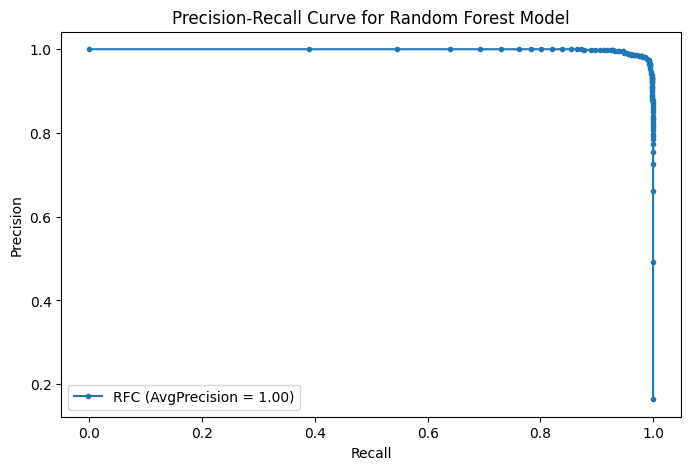

In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

avg_precision = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, marker='.', label=f'RFC (AvgPrecision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest Model')
plt.legend()
plt.show()


Feature importance 

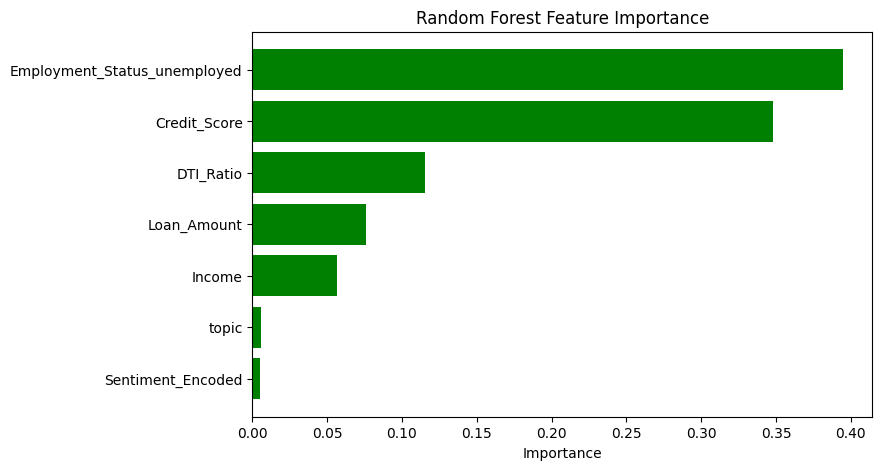

In [54]:
importance = rfc_model.feature_importances_
feature_name = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_name,
     'Importance':importance}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(feat_imp_df['Feature'],feat_imp_df['Importance'], color='green')
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.show()

### Final Insight 

top 3 Strong influencers on approved loans are Employement status, Credit score, DTI_ratios.

 Model can be trusted (Even with High Scores):
        
        1. No Data Leakage
            •	Split  data properly before applying SMOTE and scaling.
            
            •	pipeline preserves integrity across preprocessing, training, validation, and testing.
                
        2. Model Generalized Better on Test Set
            •	The test set scores improved, especially for class 1 (approved loans) — the class that actually costs money if you get it wrong.
            •	This is not overfitting — it’s a signal of a stable and generalizable model.
        
        3. These are elite but believable numbers, especially with:
            •	Well-engineered features (sentiment, topic)
            •	Balanced training with SMOTE
            •	Validation before test